In [8]:
import mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector


In [9]:
# Configuration Variables
NUM_LENDERS = 1
NUM_BORROWERS = 100
STARTING_CREDIT_SCORE = 700
LOAN_AMOUNT = 100  # This will become the default, but individual amounts will be randomized
REPAYMENT_PROBABILITY = 0.8
DEFAULT_CREDIT_PENALTY = 100

# New randomization parameters
MIN_OWN_CAPITAL = 0
MAX_OWN_CAPITAL = 1000000
MIN_MONTHLY_INCOME = 500
MAX_MONTHLY_INCOME = 15000
MIN_LOAN_AMOUNT = 2000
MAX_LOAN_AMOUNT = 500000

# Fixed loan terms parameters
INTEREST_RATE = 0.025  # 2.5% per annum
REPAYMENT_PERIOD_YEARS = 15  # 15 years
STEPS_PER_YEAR = 12  # Assuming monthly steps

# Calculated variables
NUM_STEPS = int(REPAYMENT_PERIOD_YEARS * STEPS_PER_YEAR)  # Automatically calculated

In [10]:
class Borrower(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.has_active_loan = False
        self.defaulted = False
        self.loan_amount = 0
        self.remaining_balance = 0
        self.monthly_payment = 0
        self.remaining_payments = 0
        self.credit_score = STARTING_CREDIT_SCORE
        
        # Randomized borrower characteristics
        self.own_capital = self.random.uniform(MIN_OWN_CAPITAL, MAX_OWN_CAPITAL)
        self.monthly_income = self.random.uniform(MIN_MONTHLY_INCOME, MAX_MONTHLY_INCOME)
        self.desired_loan_amount = self.random.uniform(MIN_LOAN_AMOUNT, MAX_LOAN_AMOUNT)

    def calculate_monthly_payment(self, principal, annual_rate, years):
        """Calculate monthly payment using standard loan formula"""
        monthly_rate = annual_rate / 12
        num_payments = years * 12
        if monthly_rate == 0:
            return principal / num_payments
        return principal * (monthly_rate * (1 + monthly_rate)**num_payments) / ((1 + monthly_rate)**num_payments - 1)

    def step(self):
        if not self.has_active_loan and not self.defaulted:
            # Try to request a loan
            lenders = [a for a in self.model.schedule.agents if isinstance(a, Lender)]
            if lenders:
                lender = self.random.choice(lenders)
                if lender.issue_loan(self):
                    self.has_active_loan = True
                    self.loan_amount = self.desired_loan_amount
                    self.remaining_balance = self.desired_loan_amount
                    
                    # Use fixed loan terms
                    self.monthly_payment = self.calculate_monthly_payment(
                        self.loan_amount, INTEREST_RATE, REPAYMENT_PERIOD_YEARS
                    )
                    self.remaining_payments = int(REPAYMENT_PERIOD_YEARS * STEPS_PER_YEAR)
                    
        elif self.has_active_loan and self.remaining_payments > 0:
            # Decide whether to make payment or default
            # Consider affordability: can they afford the payment?
            can_afford = self.monthly_payment <= (self.monthly_income * 0.4)  # 40% debt-to-income ratio
            
            if self.random.random() < REPAYMENT_PROBABILITY and can_afford:
                # Make payment
                self.remaining_balance -= self.monthly_payment
                self.remaining_payments -= 1
                
                # Check if loan is fully paid
                if self.remaining_payments <= 0 or self.remaining_balance <= 0:
                    self.has_active_loan = False
                    self.loan_amount = 0
                    self.remaining_balance = 0
                    self.monthly_payment = 0
                    self.remaining_payments = 0
            else:
                # Default
                self.defaulted = True
                self.has_active_loan = False
                self.loan_amount = 0
                self.remaining_balance = 0
                self.monthly_payment = 0
                self.remaining_payments = 0
                self.credit_score -= DEFAULT_CREDIT_PENALTY

In [11]:
class Lender(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.portfolio_size = 0

    def issue_loan(self, borrower):
        # Simple rule: always issue loan if borrower hasn't defaulted
        if not borrower.defaulted:
            self.portfolio_size += 1
            return True
        return False

    def step(self):
        # Lender could review portfolio, but here does nothing
        pass


In [12]:
class CreditModel(Model):
    def __init__(self, num_lenders, num_borrowers):
        super().__init__()
        self.num_lenders = num_lenders
        self.num_borrowers = num_borrowers
        self.schedule = RandomActivation(self)

        # Create lenders
        for i in range(self.num_lenders):
            lender = Lender(i, self)
            self.schedule.add(lender)

        # Create borrowers
        for j in range(self.num_borrowers):
            borrower = Borrower(self.num_lenders + j, self)
            self.schedule.add(borrower)

        # Data collector
        self.datacollector = DataCollector(
            model_reporters={
                "ActiveLoans": lambda m: sum([1 for a in m.schedule.agents if isinstance(a, Borrower) and a.has_active_loan]),
                "Defaults": lambda m: sum([1 for a in m.schedule.agents if isinstance(a, Borrower) and a.defaulted]),
                "OutstandingCredit": lambda m: sum([a.remaining_balance for a in m.schedule.agents if isinstance(a, Borrower) and a.has_active_loan]),
                "TotalMonthlyPayments": lambda m: sum([a.monthly_payment for a in m.schedule.agents if isinstance(a, Borrower) and a.has_active_loan]),
                "AvgCreditScore": lambda m: sum([a.credit_score for a in m.schedule.agents if isinstance(a, Borrower)]) / max(1, sum([1 for a in m.schedule.agents if isinstance(a, Borrower)])),
                "AvgOwnCapital": lambda m: sum([a.own_capital for a in m.schedule.agents if isinstance(a, Borrower)]) / max(1, sum([1 for a in m.schedule.agents if isinstance(a, Borrower)])),
                "AvgMonthlyIncome": lambda m: sum([a.monthly_income for a in m.schedule.agents if isinstance(a, Borrower)]) / max(1, sum([1 for a in m.schedule.agents if isinstance(a, Borrower)]))
            },
            agent_reporters={
                "LoanStatus": lambda a: getattr(a, "has_active_loan", None),
                "PortfolioSize": lambda a: getattr(a, "portfolio_size", None),
                "OwnCapital": lambda a: getattr(a, "own_capital", None),
                "MonthlyIncome": lambda a: getattr(a, "monthly_income", None),
                "DesiredLoanAmount": lambda a: getattr(a, "desired_loan_amount", None),
                "RemainingBalance": lambda a: getattr(a, "remaining_balance", None),
                "MonthlyPayment": lambda a: getattr(a,"remaining_payments", None)
            }
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [13]:
# Create and run the model
model = CreditModel(num_lenders=NUM_LENDERS, num_borrowers=NUM_BORROWERS)  # Use configuration variables
for i in range(NUM_STEPS):  # Use configuration variable
    model.step()


     ActiveLoans  Defaults  OutstandingCredit  TotalMonthlyPayments  \
0              0         0       0.000000e+00              0.000000   
1            100         0       2.373602e+07         158269.241002   
2             61        39       1.178721e+07          79123.440222   
3             48        52       9.266844e+06          62625.472917   
4             39        61       7.102835e+06          48327.668333   
..           ...       ...                ...                   ...   
175            0       100       0.000000e+00              0.000000   
176            0       100       0.000000e+00              0.000000   
177            0       100       0.000000e+00              0.000000   
178            0       100       0.000000e+00              0.000000   
179            0       100       0.000000e+00              0.000000   

     AvgCreditScore  AvgOwnCapital  AvgMonthlyIncome  
0             700.0  487559.589674        8257.96628  
1             700.0  487559.589674   

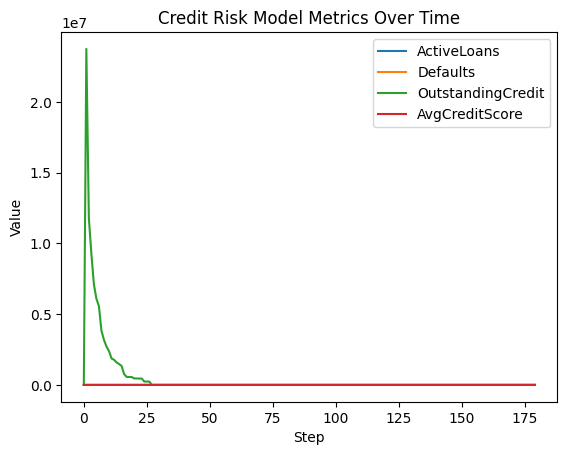

In [14]:
# Convert collected model data to a DataFrame
model_data = model.datacollector.get_model_vars_dataframe()
print(model_data)

# Optionally, plot results if using matplotlib
import matplotlib.pyplot as plt

model_data[["ActiveLoans", "Defaults", "OutstandingCredit", "AvgCreditScore"]].plot()
plt.xlabel("Step")
plt.ylabel("Value")
plt.title("Credit Risk Model Metrics Over Time")
plt.show()
